In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from qids_lib import QIDS
import numpy as np
import torch
import torch.nn as nn
from torch import nn, Tensor
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import pandas as pd
from pipeline import Dataset, backtest
from matplotlib import pyplot as plt
from datatools import data_quantization, check_dataframe, extract_market_data
from sklearn.model_selection import TimeSeriesSplit
from tqdm.auto import tqdm, trange
from pandas import Series, DataFrame, MultiIndex
from visualization.metric import Performance
from sklearn.metrics import r2_score
from visualization.metric import plot_performance
from qids_lib import QIDS

In [4]:
dataset = Dataset.load('../../data/parsed')

In [5]:
qids = QIDS(path_prefix='../../')

In [6]:
class oneDVerConvNet(nn.Module): # type3 - 1D Vertical Convolution
    def __init__(self, D_in, D_out, input_shape, b_size):
        # input_shape: without batch dimension
        # b_size: batch size
        super(oneDVerConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(D_in, 16, (3,1), stride = (1,1), padding = (1,0)),
            # nn.BatchNorm2d(16), # no batch
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,1), stride = (2,1)))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size = (3,1), stride = (1,1), padding= (1,0)),
            # nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,1), stride = (2,1)))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 256, kernel_size = (3,1), stride = (1,1), padding= (1,0)),
            # nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,1), stride = (2,1)))
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 1024, kernel_size = (3,1), stride = (1,1), padding= (1,0)),
            # nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,1), stride = (2,1)))
        self.drop_out = nn.Dropout()
        n_size = self._get_conv_output(input_shape, b_size)
        # print(n_size)
 #       self.fc1 = nn.Linear(n_size, 256)
 #        self.fc1 = nn.Linear(1024, 256)
 #        self.fc2 = nn.Linear(256, 64)
 #        self.fc3 = nn.Linear(64,D_out)
        self.transform1 = nn.Conv2d(n_size, 256, kernel_size = (1,1), stride = (1,1), padding=0)
        self.transform2 = nn.Conv2d(256, 64, kernel_size = (1,1), stride = (1,1), padding=0)
        self.transform3 = nn.Conv2d(64, D_out, kernel_size = (1,1), stride = (1,1), padding=0)
        # self.bn1 = nn.BatchNorm1d(256)
        # self.bn2 = nn.BatchNorm1d(64)

    def _get_conv_output(self, shape, b_size):
        input = Variable(torch.rand(b_size, *shape))
        output_feat = self._forward_features(input)
        n_size = output_feat.data.view(b_size, -1).size(1)
        return n_size

    def _forward_features(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # print(x.shape) # shape = (b_size, feature=1024, H=1, W = 54)
        x = torch.max(x,3)[0]
        return x

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # x = torch.max(x,3)[0] # questionable maybe do along [1]
        # print(x.shape) # shape = (b_size, feature=1024, H=1) after max
        #print(x.data.size())
        # x = x.view(-1,self.num_flat_features(x))
#        print(x.data.size())
#         x = F.relu(self.bn1(self.fc1(x)))
#         x = F.relu(self.bn2(self.drop_out(self.fc2(x))))
        x = F.relu(self.transform1(x))
        x = F.relu(self.drop_out(self.transform2(x)))
        x = self.transform3(x)
##        return x, new_features, contribution
        return x.squeeze()

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


In [53]:
class NN_wrapper():
    def __init__(self, net_path, lookback_window, optimizer,
                 learning_rate = 0.003, criterion = nn.MSELoss(), n_epoch = 3):

        self.net = oneDVerConvNet(D_in=7, D_out=1, input_shape=(7,lookback_window,54), b_size=1)
        self.net.load_state_dict(torch.load(net_path))
        self.lookback_window = lookback_window
        self.learning_rate = learning_rate
        self.criterion = criterion
        if optimizer == 'LBFGS':
            self.optimizer = optim.LBFGS(self.net.parameters(), lr=learning_rate)
        elif optimizer == 'ADAM':
            self.optimizer = optim.Adam(self.net.parameters(), lr=learning_rate, betas = (0.9, 0.999))
        else:
            raise ValueError('Optimizer not supported')
        self.optim_name = optimizer
        self.n_epoch = n_epoch

    def fit(self, X, y):
        self.net.train()
        torch.manual_seed(3407)
        X_np = X.swaplevel(1,0).sort_index(ascending=True).to_numpy().astype(np.float32)
        for epoch in range(self.n_epoch):
            for i in range(int(X.shape[0]/(self.lookback_window*54))):
                # print('look back day:', int(X.shape[0]/(self.lookback_window*54)))
                X_np_day = X_np[i*(self.lookback_window*54):(i+1)*(self.lookback_window*54),:]

                # shape (asset, days, feature) -> (ft, days, asset)
                X_np_tensor = X_np_day.reshape(54,self.lookback_window,-1).transpose([2,1,0])
                X_np_tensor = X_np_tensor[np.newaxis,:]  # add batch dimension
                X_torch = torch.from_numpy(X_np_tensor)
                labels = torch.tensor(y[-54:].values).to(torch.float)
                # print('its actually training')
                def closure():
                    self.optimizer.zero_grad()
                    outputs=self.net(X_torch)
                    loss = self.criterion(outputs, labels)
                    loss.backward()
                    return loss
                self.optimizer.zero_grad()
                outputs = self.net(X_torch)
                loss = self.criterion(outputs, labels)
                loss.backward()
                if self.optim_name == 'LBFGS':
                    self.optimizer.step(closure) # need closure for LBFGS
                else:
                    self.optimizer.step()
        return


    def predict(self, X):
        self.net.eval()
        # print(X)
        torch.manual_seed(3407)
        X_np = X.swaplevel(1,0).sort_index(ascending=True).to_numpy().astype(np.float32)
        # shape (asset, days, feature) -> (ft, days, asset)
        X_np_tensor = X_np.reshape(54,self.lookback_window,-1).transpose([2,1,0])
        X_np_tensor = X_np_tensor[np.newaxis,:]  # add batch dimension
        X_torch = torch.from_numpy(X_np_tensor)
        y = self.net(X_torch)
        return np.clip(y.detach().numpy(), -0.2, 0.2)


In [70]:
net_path = '../../model/dump/1DConv_original'
train_lookback = 32
eval_lookback = 16
n_epoch = 3
lr = 0.005
criterion = nn.MSELoss()
# optimizer = 'LBFGS'
optimizer = 'ADAM'
original_feature = ['turnoverRatio', 'transactionAmount', 'pb', 'ps', 'pe_ttm', 'pe', 'pcf']
from pipeline.backtest import evaluation_for_submission
performance = evaluation_for_submission(NN_wrapper(net_path, eval_lookback, optimizer=optimizer, learning_rate = lr,
                                                   criterion=criterion,n_epoch=n_epoch),
                                        feature_columns=original_feature,
                                        dataset=dataset, df=dataset.fundamental, qids=qids, lookback_window=train_lookback,
                                        eval_lookback_window=eval_lookback,)



/Users/lewisliu/Desktop/Study/Graduate_Study_Austin/Career/Practice/qids-2023-comp/pipeline/backtest.py:163: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  return_list.append(return_0.groupby(level=1).apply(lambda df: df.shift(i).bfill()).rename(f'return_{i}'))
/Users/lewisliu/Desktop/Study/Graduate_Study_Austin/Career/Practice/qids-2023-comp/pipeline/backtest.py:163: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(...

  0%|          | 0/700 [00:00<?, ?it/s]

Data Feeding is finished.


The ending score for metric train_r2 is: -7.1762e+06
The ending score for metric test_cum_r2 is: -2.0853e+06
The ending score for metric test_cum_pearson is: 5.6610e-03


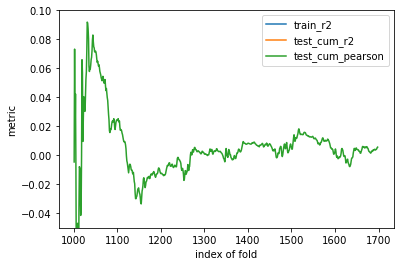

In [39]:
plt.figure()
plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
# plot_performance(performance, metrics_selected=['train_r2', 'val_cum_pearson','val_cum_r2'])
plt.show()



The ending score for metric train_r2 is: 0.0000e+00
The ending score for metric test_cum_r2 is: -2.1566e+06
The ending score for metric test_cum_pearson is: 5.6774e-03


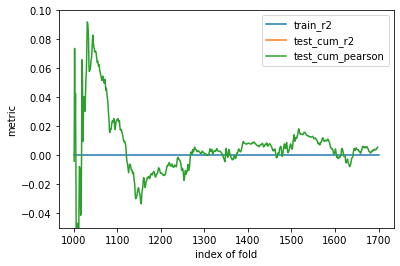

In [55]:
plt.figure()
plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
# plot_performance(performance, metrics_selected=['train_r2', 'val_cum_pearson','val_cum_r2'])
plt.show()



The ending score for metric train_r2 is: 0.0000e+00
The ending score for metric test_cum_r2 is: -8.4987e+00
The ending score for metric test_cum_pearson is: -2.3044e-02


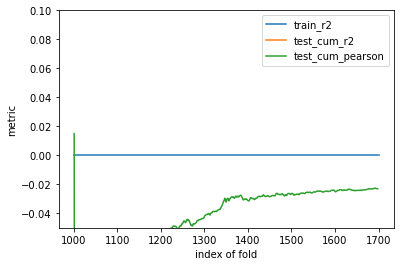

In [57]:
plt.figure()
plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
# plot_performance(performance, metrics_selected=['train_r2', 'val_cum_pearson','val_cum_r2'])
plt.show()


The ending score for metric train_r2 is: 0.0000e+00
The ending score for metric test_cum_r2 is: -2.2353e+00
The ending score for metric test_cum_pearson is: 2.0017e-02


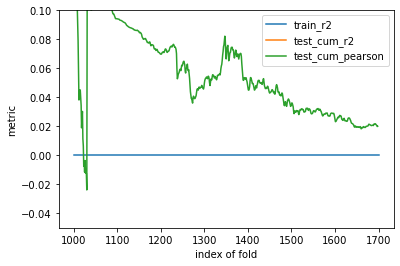

In [59]:
# nepoch = 5, lr = 0.01, ADAM, lookback3
plt.figure()
plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
# plot_performance(performance, metrics_selected=['train_r2', 'val_cum_pearson','val_cum_r2'])
plt.show()

The ending score for metric train_r2 is: 0.0000e+00
The ending score for metric test_cum_r2 is: -1.8115e+08
The ending score for metric test_cum_pearson is: 5.3160e-04


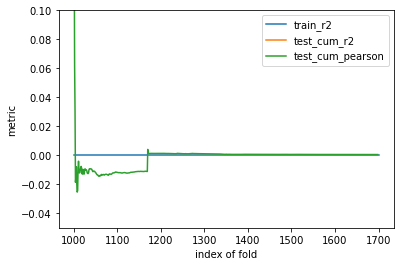

In [61]:
# nepoch = 10, lr = 0.05, ADAM, lookback3
plt.figure()
plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
# plot_performance(performance, metrics_selected=['train_r2', 'val_cum_pearson','val_cum_r2'])
plt.show()

The ending score for metric train_r2 is: 0.0000e+00
The ending score for metric test_cum_r2 is: -1.0497e+00
The ending score for metric test_cum_pearson is: -1.0187e-02


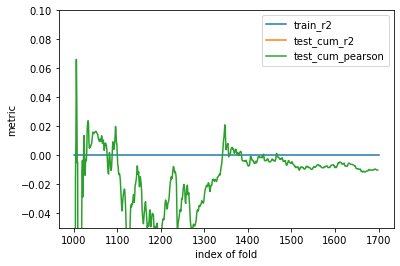

In [63]:
# nepoch = 10, lr = 0.01, ADAM. lookback3
plt.figure()
plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
# plot_performance(performance, metrics_selected=['train_r2', 'val_cum_pearson','val_cum_r2'])
plt.show()

The ending score for metric train_r2 is: 0.0000e+00
The ending score for metric test_cum_r2 is: -3.1191e+00
The ending score for metric test_cum_pearson is: 1.9287e-02


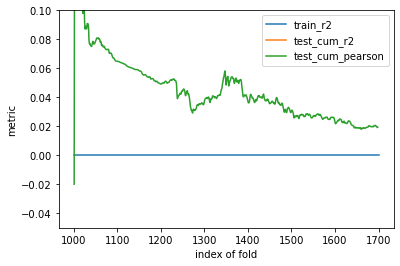

In [65]:
# nepoch = 5, lr = 0.01, ADAM, lookback3, fix seed, clipped
plt.figure()
plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
# plot_performance(performance, metrics_selected=['train_r2', 'val_cum_pearson','val_cum_r2'])
plt.show()


The ending score for metric train_r2 is: 0.0000e+00
The ending score for metric test_cum_r2 is: -8.8608e-01
The ending score for metric test_cum_pearson is: -1.7387e-02


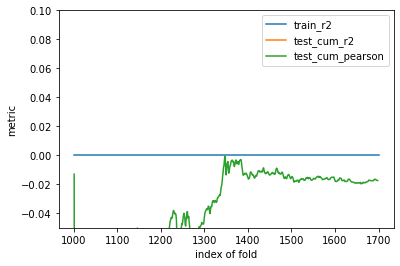

In [67]:
# nepoch = 5, lr = 0.005, ADAM, lookback3, fix seed, clipped
plt.figure()
plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
# plot_performance(performance, metrics_selected=['train_r2', 'val_cum_pearson','val_cum_r2'])
plt.show()



The ending score for metric train_r2 is: 0.0000e+00
The ending score for metric test_cum_r2 is: -2.0205e+02
The ending score for metric test_cum_pearson is: -2.3839e-02


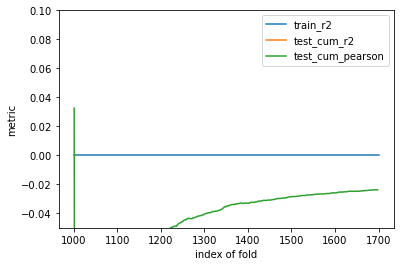

In [69]:
# nepoch = 3, lr = 0.005, ADAM, lookback1, fix seed, clipped
plt.figure()
plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
# plot_performance(performance, metrics_selected=['train_r2', 'val_cum_pearson','val_cum_r2'])
plt.show()



The ending score for metric train_r2 is: 0.0000e+00
The ending score for metric test_cum_r2 is: -3.5374e+00
The ending score for metric test_cum_pearson is: -2.2336e-02


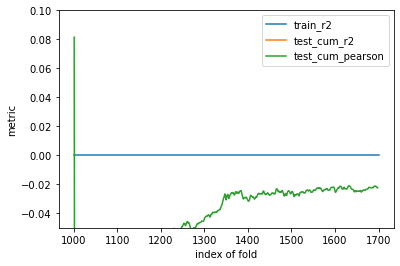

In [71]:
# nepoch = 3, lr = 0.005, ADAM, lookback2, fix seed, clipped
plt.figure()
plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
# plot_performance(performance, metrics_selected=['train_r2', 'val_cum_pearson','val_cum_r2'])
plt.show()

